**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Comparing neural networks and logistic regression in music classification* 

## Abstract

This project compares logistic regression and neural networks in music classification. 

## 1. Introduction

Building a classifier nowadays is easier than ever, though building a good classifier is still a hard task despite the high availability of efficient tools created for this purpose. We wanted to investigate the performance of a minimally-tuned neural network in classification using out-of-the-box libraries and compare them to logistic regression. We chose Keras because of its popularity and documentation availability and SciKit-learn for the logistic regression implementation.

The data usually has many problems some of which cannot be known beforehand. Preprocessing and visualisation are necessary for building a proper model. However, data analysis is already quite ubiquitous and the need for better tools is ever-growing. Some people, who would benefit from machine learning and data analysis, might not even be aware of the current progress of the field nor the tools at all. If these people were made aware of the field it will overall benefit the society we live in. To this day, it still requires a data scientist/engineer to build the models because of the various bottlenecks present in data science. 

## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*

The supplied data contains 4363 labeled samples and 6544 unlabeled sample vectors. Every sample is a vector of length 264 which is composed of preprocessed properties of the original time-series data. There are 10 labels and the class distribution is unbalanced; almost half of the labeled samples have the same label which could lead to problems in classification. For example, we don't want the classifier to learn the class distribution of the training set because the class distribution might be completely different for the evaluation set. Some of the fields in the data contain almost identical values for the whole dataset which means these features cannot be used to differentiate samples. Some of the features may also be redundant and contribute nothing while having high variance amongst the dataset. 

In [43]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Load the data from file:

In [44]:
train_data = pd.read_csv('data/train_data.csv', header=None).values
labels = pd.read_csv('data/train_labels.csv', header=None).values

Plot the label distribution of the training data:

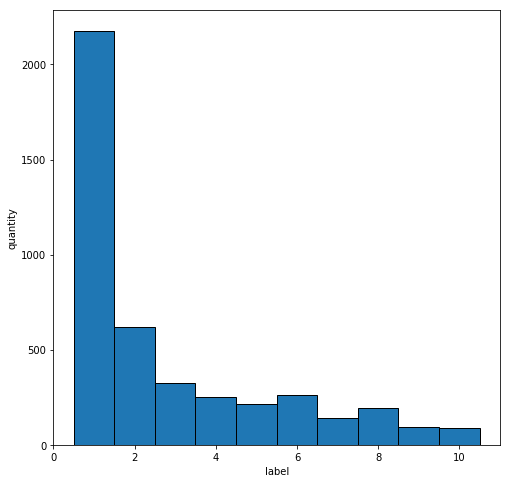

In [45]:
# plot label distribution in training data
plt.figure(1, figsize=(8, 8))
plt.hist(labels, range=(0.5,10.5), bins=10, ec='black')
plt.xlabel('label')
plt.ylabel('quantity')
plt.show()

Here the class imbalance can be seen clearly. It is also good to find out if the data is ordered to know if it needs to suffled before dividing it to training data and validation data. Here is a simple plot of the distribution of the labels in the csv file:

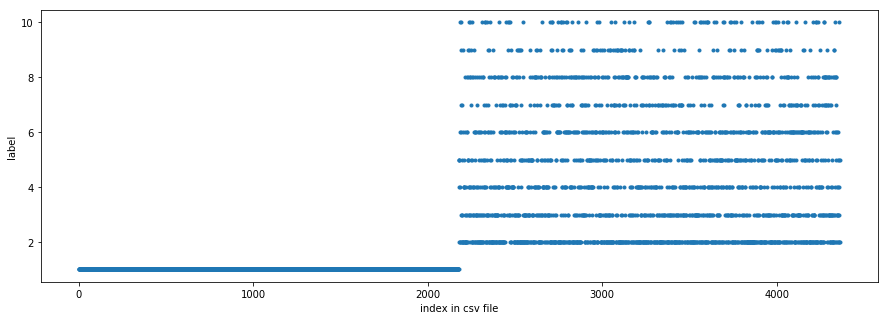

In [46]:
plt.figure(2, figsize=(15, 5))
plt.plot(labels, marker='.', linestyle = 'None')
plt.xlabel('index in csv file')
plt.ylabel('label')
plt.show()

We can see that Pop-rock songs are first in the file and the rest of the genres are distributed randomly after that.

### Principal components analysis

We can understand the dimensionality better by principal components analysis. Here is a class that is created on basis of the last Python exercise of this course:

In [47]:
class PCA:
    def __init__(self, data, d):
        self.data = data # raw data
        self.d = d # number of dimensions in the compressed data
        self.W_pca, self.eigvalues = self.compute_pca()

    def compute_pca(self):
        # Output: a d by D matrix W_pca, and all eigenvalues of Q

        N = self.data.shape[0]
        # step1: compute the sample cov. matrix Q
        Q = np.matmul(np.transpose(self.data), self.data ) / N
        #step2: compute the eigenvalues and eigenvectors
        w, v = np.linalg.eig(Q)
        #step3: Sort the eigenvectors by decreasing eigenvalues, choose the d largest eigenvalues, form W_pca
        ind = np.argsort(w)[::-1]
        W_pca = np.empty((self.d, self.data.shape[1]))
        eigvalues = w
        for i in range(self.d):
            W_pca[i] = v[:,ind[i]]
        
        return W_pca.real, eigvalues # discard imaginary part

    def plot_error(self,  max_d):
        x=range(1,max_d+1)
        errors=[sum(self.eigvalues[d:]) for d in x]
        plt.plot(x, errors)
        plt.xlabel('Number of principal components $d$')
        plt.ylabel('Reconstruction error $\mathcal{E}$')
        plt.title('Number of principal components vs the reconstruction error')
        plt.show()

    def plot_scatter(self):
        # get x for d=2
        X_2d = np.matmul(self.W_pca[:2,:],self.data[:,:,None])[:,:,0]
        plt.figure(1, figsize=(10, 10))   
        plt.scatter(X_2d[:2178,0], X_2d[:2178,1], 3, marker='o', color='blue')
        plt.scatter(X_2d[2178:,0], X_2d[2178:,1], 3, marker='x', color='red')
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.show()

    
    def low_dim_data(self):
        new_data = np.ndarray((self.data.shape[0], self.d))
        for i in range(self.data.shape[0]):
            new_data[i] = np.matmul(self.W_pca, self.data[i])
        return new_data


To see roughly the ratio between the first, i.e. largest, principal components, the first five eigenvalues are printed and the reconstruction error is plotted for the first 30 principal components:

C:\Users\Anssi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Anssi\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


The first 5 principal component eigenvalues:
 [4.00299038e+12 7.40049027e+08 5.90703291e+08 2.63947178e+08
 1.78854204e+08]


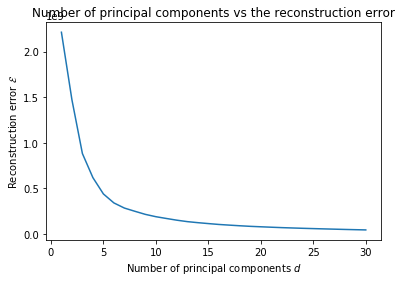

In [48]:
pca = PCA(train_data, 50)
print('The first 5 principal component eigenvalues:\n', pca.eigvalues[:5].real)
# plot the number of principal components vs the reconstruction error
pca.plot_error(30)

We see that the first component is about four orders of magnitude larger than the second. A scetterplot can be created where the first two components are used as axes. To try to understand how the labels are distributed in this space, we colour the Pop-rock genre as blue and the rest red:

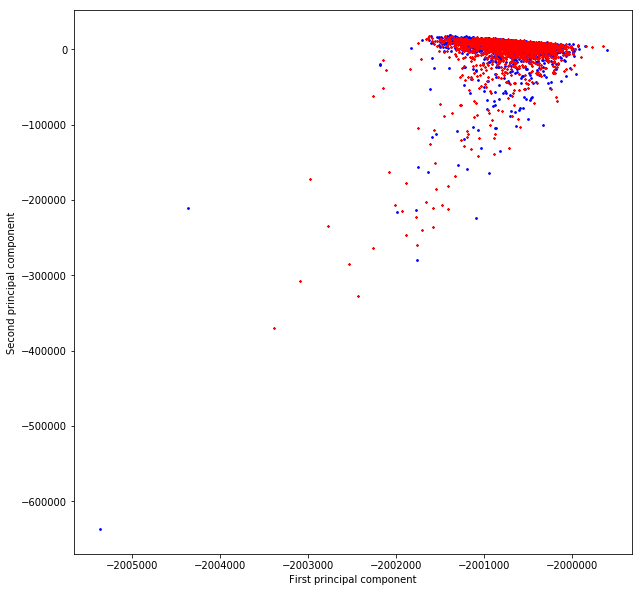

In [49]:
pca.plot_scatter()

This does not show clear division or clustering of the labels in this 2D space. The data can be scaled with a scikit-learn method and we try the PCA again:

In [50]:
from sklearn import preprocessing
scaled_data = preprocessing.scale(train_data)

[69.46388432 26.52210249 14.06929455  9.70100502  6.915734  ]


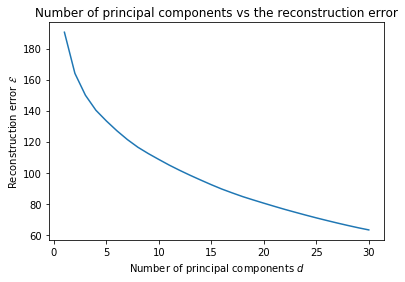

In [51]:
pca_scaled = PCA(scaled_data, 50)
print(pca_scaled.eigvalues[:5].real)
# plot the number of principal components vs the reconstruction error
pca_scaled.plot_error(30)

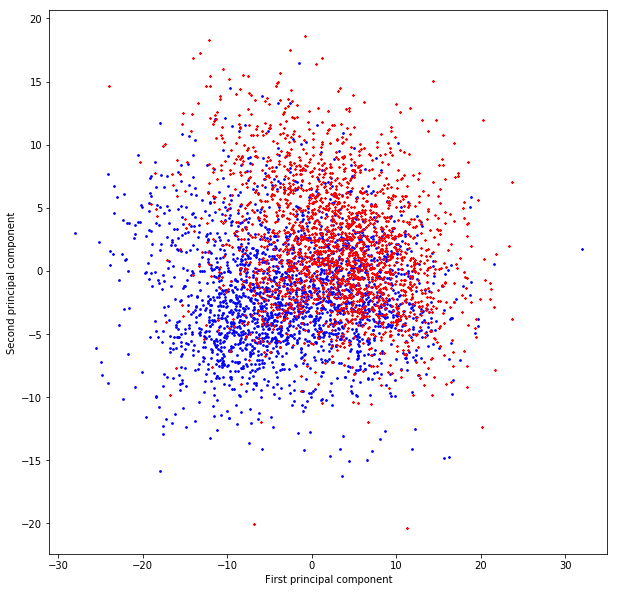

In [52]:
pca_scaled.plot_scatter()

From this scatterplot can be seen a slight shift in the direction of the 1st and 2nd principal components if we compare the Pop-rock class to the other classes. While the distrinction is quite clear there are still many datapoints which reside in both sides of the scatterplot indicating some similarities between different classes.

## 3. Methods and experiments

We tried a few different methods including logistic regression, neural networks and clustering. The first two gave sufficient results while clustering gave a very poor accuracy (we suspect this is because the dataset is unbalanced which leads to problems with clustering algorithms).

### SciKit-learn library

The data is divided to training and validatation data after suffling. Logistic regression was done using the SciKit-learn library.

In [53]:
ratio = 0.8

temp = np.hstack((labels, scaled_data))
np.random.shuffle(temp)
num = int(ratio * temp.shape[0])
train_data = temp[:num, 1:]
train_labels = temp[:num, :1]
val_data = temp[num:, 1:]
val_labels = temp[num:, :1]


In [54]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial', max_iter=100, verbose=1)

model = clf.fit(train_data, train_labels)
prediction = model.predict(val_data)

# plot label distribution in prediction
print("train score: ", clf.score(train_data, train_labels))
print("test score: ", clf.score(val_data, val_labels))

C:\Users\Anssi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_iter reached after 9 seconds
train score:  0.7386819484240688
test score:  0.6345933562428407


C:\Users\Anssi\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished


### Deep network with Keras

We wanted to test how a modern neural network library performs. We first separated the data into thee distrinct categories according to the data description: rhythm, chroma and MFCC. We then put each of these in separate inputs and made a shallow network to interpret the data. Afterward we combined the results into a single layer which was followed by a deep layer composition. The hyperparameters were chosen mainly by testing out different ones and looking for the best ones. Last layer uses softmax activation explicitly since we wanted to use the same results for both competitions. Log-loss values were the direct values from the last layer and labels where chosen by the largest element in the 10-long label vector.

We created a preprocessor class that does the scaling and other handling of the data, such as dividing it. We tried also balancing the data by generating new rows of the underrepresented classes. These new rows were copied instaces of the existing rows with some noise added to them.

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn import preprocessing

class Preprocessor:

	def __init__(self, path='data/', balance=True, mutation_rate=5e-2, scale=True):
		self.balance 		 = balance
		self.scale 			 = scale
		self.mutation_rate 	 = mutation_rate
		self.data_path 		 = path
		self.raw_data_labels = pd.read_csv(self.data_path + 'train_labels.csv', header=None)
		self.unique_labels	 = np.unique(self.raw_data_labels)
		self.raw_data 		 = self.load_raw_data('train_data.csv')
		self.test_data		 = self.load_raw_data('test_data.csv')

	def load_raw_data(self, file):
		data = pd.read_csv(self.data_path + file, header=None).values
		if self.scale:
			data = preprocessing.scale(data)
		return data

	def balance_raw_data(self, data, labels, save_bal_data, bal_data_path):
		distribution = {}
		raw = np.hstack((labels, data))
		for label in self.unique_labels:
			distribution[int(label)] = 0
		for label in labels:
			distribution[int(label)] += 1
		distmax = distribution[max(distribution, key=distribution.get)]
		amount = 0
		for key in distribution:
			amount += distmax - distribution[key]
		count = 0
		tmp = np.empty((0, 265))
		for label in self.unique_labels:
			auxiliary_rows = raw[raw[:, 0] == label]
			for _ in range(distmax - distribution[label]):
				to_add = auxiliary_rows[np.random.randint(auxiliary_rows.shape[0])]
				for elem in range(to_add.shape[0] - 1):
					rnd = np.random.uniform(1 - self.mutation_rate, 1 + self.mutation_rate)
					to_add[elem + 1] *= rnd
				count += 1
				if count % 1000 == 0:
					print("Processed count: ", count, "/", amount)
				tmp = np.append(tmp, [to_add], axis=0)
		raw = np.vstack((raw, tmp))
		# optionally saves the data
		# boolean save_bal_data and save path is given to class method 'divided_data()'
		if save_bal_data:
			pd.DataFrame(raw).to_csv(bal_data_path)
		new_labels = raw[:, :1]
		new_features = raw[:, 1:]
		return new_features, new_labels

	def label_filter(self, row, label: int):
		#print(int(row[0])
		return row[0] == label

	# loads all feature vectors from training data and validation data for unsupervised learning
	# shape: (num_of_vectors, 264)
	def all_feature_vectors(self):
		pass

	# transforms the label data to vectors, for example: 2 => (0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
	# shape: 
	def transformed_labels(self, data):
		unique_labels = np.unique(self.raw_data_labels)
		labels = np.zeros((data.shape[0], unique_labels.shape[0]))
		for i in range(data.shape[0]):
			labels[i][int(data[i]) - 1] = 1
		assert labels.shape == (data.shape[0], unique_labels.shape[0])
		return labels

	# normalises columns to [0.0, 1.0]
	def normalize_data(self, data):
		transformed = data
		print(type(data))
		return transformed

	# divides training data according to ratio for training purposes: (training_data, training_labels), (testing_data, testing_labels)
	# shape: (ratio*4263, col), ((1 - ratio)*4363, col)
	# loads preprocessed data from file or preprocesses the data and optionally saves to file
	def divided_data(self, ratio=0.5, bal_data_path=None, load_bal_data=True, save_bal_data=False):
		# path to balanced data file is used for both loading and saving the file
		if not bal_data_path:
			# appends ratio in percentages to file name
			bal_data_path = self.data_path + 'bal_data_ratio_' + str(int(100*ratio)) + '.csv'

		raw = np.hstack((self.raw_data_labels, self.raw_data))
		np.random.shuffle(raw)
		num = int(ratio * raw.shape[0])
		training_data = raw[:num, 1:]
		training_labels = raw[:num, :1]

		# balance the data
		if (self.balance and not load_bal_data):
			training_data, training_labels = self.balance_raw_data(training_data, training_labels, save_bal_data, bal_data_path)

		# use old balanced data file
		if (self.balance and load_bal_data):
			raw = pd.read_csv(bal_data_path, header=None).values
			# pandas puts headers as first column and row
			training_labels = raw[1:, 1:2]
			training_data = raw[1:, 2:]

		testing_data = raw[num:, 1:]
		testing_labels = raw[num:, :1]
		return training_data, training_labels, testing_data, testing_labels

	# returns columns (1-168)
	# shape: (row, 168)
	def get_rhythm_patterns(self, data):
		return data[:,0:168]

	# return columns (169-216)
	# shape: (row, 48)
	def get_chroma(self, data):
		return data[:,168:216]

	# return columns 217-264
	# shape: (row, 48)
	def get_mfcc(self, data):
		return data[:,216:]


Train on 3490 samples, validate on 873 samples
Epoch 1/300
3490/3490 [==============================] - 2s 476us/step - loss: 2.1760 - acc: 0.2625 - val_loss: 1.6489 - val_acc: 0.5235
Epoch 2/300
3490/3490 [==============================] - 0s 51us/step - loss: 1.6944 - acc: 0.4885 - val_loss: 1.4841 - val_acc: 0.5716
Epoch 3/300
3490/3490 [==============================] - 0s 57us/step - loss: 1.5610 - acc: 0.5203 - val_loss: 1.3265 - val_acc: 0.5853
Epoch 4/300
3490/3490 [==============================] - 0s 57us/step - loss: 1.4955 - acc: 0.5473 - val_loss: 1.3033 - val_acc: 0.5968
Epoch 5/300
3490/3490 [==============================] - 0s 59us/step - loss: 1.4474 - acc: 0.5530 - val_loss: 1.2724 - val_acc: 0.6048
Epoch 6/300
3490/3490 [==============================] - 0s 61us/step - loss: 1.4107 - acc: 0.5639 - val_loss: 1.2569 - val_acc: 0.6186
Epoch 7/300
3490/3490 [==============================] - 0s 68us/step - loss: 1.3775 - acc: 0.5756 - val_loss: 1.2466 - val_acc: 0.6186


3490/3490 [==============================] - 0s 63us/step - loss: 0.9803 - acc: 0.6997 - val_loss: 1.1869 - val_acc: 0.6415
Epoch 61/300
3490/3490 [==============================] - 0s 61us/step - loss: 0.9589 - acc: 0.7037 - val_loss: 1.1882 - val_acc: 0.6438
Epoch 62/300
3490/3490 [==============================] - 0s 55us/step - loss: 1.0023 - acc: 0.6903 - val_loss: 1.1910 - val_acc: 0.6392
Epoch 63/300
3490/3490 [==============================] - 0s 56us/step - loss: 0.9769 - acc: 0.6931 - val_loss: 1.1967 - val_acc: 0.6346
Epoch 64/300
3490/3490 [==============================] - 0s 56us/step - loss: 0.9697 - acc: 0.6963 - val_loss: 1.1895 - val_acc: 0.6426
Epoch 65/300
3490/3490 [==============================] - 0s 56us/step - loss: 0.9746 - acc: 0.6928 - val_loss: 1.1839 - val_acc: 0.6472
Epoch 66/300
3490/3490 [==============================] - 0s 56us/step - loss: 0.9697 - acc: 0.7060 - val_loss: 1.1961 - val_acc: 0.6403
Epoch 67/300
3490/3490 [==============================

Epoch 120/300
3490/3490 [==============================] - 0s 59us/step - loss: 0.8089 - acc: 0.7510 - val_loss: 1.2702 - val_acc: 0.6380
Epoch 121/300
3490/3490 [==============================] - 0s 58us/step - loss: 0.8353 - acc: 0.7378 - val_loss: 1.2436 - val_acc: 0.6369
Epoch 122/300
3490/3490 [==============================] - 0s 55us/step - loss: 0.8234 - acc: 0.7556 - val_loss: 1.2655 - val_acc: 0.6392
Epoch 123/300
3490/3490 [==============================] - 0s 59us/step - loss: 0.8280 - acc: 0.7456 - val_loss: 1.2351 - val_acc: 0.6438
Epoch 124/300
3490/3490 [==============================] - 0s 58us/step - loss: 0.7982 - acc: 0.7585 - val_loss: 1.2571 - val_acc: 0.6449
Epoch 125/300
3490/3490 [==============================] - 0s 58us/step - loss: 0.8112 - acc: 0.7450 - val_loss: 1.2756 - val_acc: 0.6426
Epoch 126/300
3490/3490 [==============================] - 0s 63us/step - loss: 0.8352 - acc: 0.7450 - val_loss: 1.2401 - val_acc: 0.6346
Epoch 127/300
3490/3490 [=========

3490/3490 [==============================] - 0s 59us/step - loss: 0.7264 - acc: 0.7688 - val_loss: 1.3101 - val_acc: 0.6369
Epoch 180/300
3490/3490 [==============================] - 0s 57us/step - loss: 0.7404 - acc: 0.7659 - val_loss: 1.3122 - val_acc: 0.6438
Epoch 181/300
3490/3490 [==============================] - 0s 58us/step - loss: 0.7589 - acc: 0.7579 - val_loss: 1.3128 - val_acc: 0.6369
Epoch 182/300
3490/3490 [==============================] - 0s 60us/step - loss: 0.7135 - acc: 0.7722 - val_loss: 1.3253 - val_acc: 0.6323
Epoch 183/300
3490/3490 [==============================] - 0s 59us/step - loss: 0.6824 - acc: 0.7885 - val_loss: 1.3290 - val_acc: 0.6300
Epoch 184/300
3490/3490 [==============================] - 0s 59us/step - loss: 0.7174 - acc: 0.7748 - val_loss: 1.3369 - val_acc: 0.6312
Epoch 185/300
3490/3490 [==============================] - 0s 66us/step - loss: 0.6949 - acc: 0.7840 - val_loss: 1.3435 - val_acc: 0.6289
Epoch 186/300
3490/3490 [=======================

3490/3490 [==============================] - 0s 57us/step - loss: 0.6697 - acc: 0.7903 - val_loss: 1.3750 - val_acc: 0.6254
Epoch 239/300
3490/3490 [==============================] - 0s 69us/step - loss: 0.6553 - acc: 0.7954 - val_loss: 1.3692 - val_acc: 0.6220
Epoch 240/300
3490/3490 [==============================] - 0s 68us/step - loss: 0.6555 - acc: 0.7954 - val_loss: 1.3986 - val_acc: 0.6403
Epoch 241/300
3490/3490 [==============================] - 0s 60us/step - loss: 0.6535 - acc: 0.7957 - val_loss: 1.3857 - val_acc: 0.6380
Epoch 242/300
3490/3490 [==============================] - 0s 68us/step - loss: 0.6786 - acc: 0.7871 - val_loss: 1.3905 - val_acc: 0.6415
Epoch 243/300
3490/3490 [==============================] - 0s 61us/step - loss: 0.6702 - acc: 0.7989 - val_loss: 1.3879 - val_acc: 0.6392
Epoch 244/300
3490/3490 [==============================] - 0s 60us/step - loss: 0.6317 - acc: 0.8057 - val_loss: 1.3912 - val_acc: 0.6323
Epoch 245/300
3490/3490 [=======================

3490/3490 [==============================] - 0s 71us/step - loss: 0.5945 - acc: 0.8175 - val_loss: 1.4490 - val_acc: 0.6334
Epoch 298/300
3490/3490 [==============================] - 0s 64us/step - loss: 0.5957 - acc: 0.8183 - val_loss: 1.4678 - val_acc: 0.6266
Epoch 299/300
3490/3490 [==============================] - 0s 59us/step - loss: 0.5993 - acc: 0.8166 - val_loss: 1.4545 - val_acc: 0.6369
Epoch 300/300
3490/3490 [==============================] - 0s 58us/step - loss: 0.5829 - acc: 0.8195 - val_loss: 1.4511 - val_acc: 0.6357


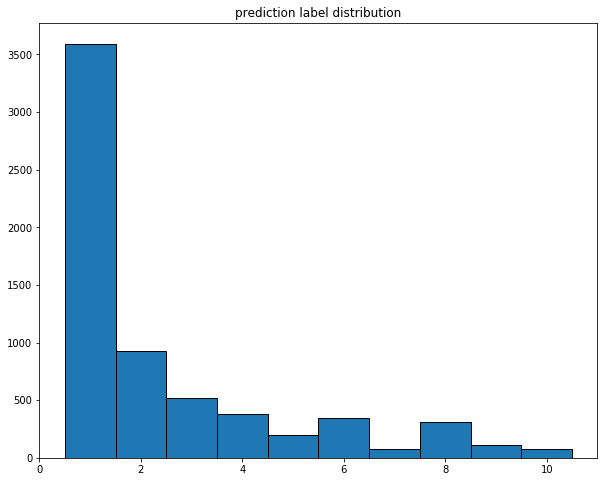

In [56]:
import keras
from keras.layers import Input, LSTM, concatenate, Dense, Dropout, BatchNormalization, GRU, GaussianNoise
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l1_l2

dl = Preprocessor(balance=False, scale=True, mutation_rate=0.15)
x_train, y_train, x_test, y_test = dl.divided_data(ratio=0.8, load_bal_data=False)
y_train = dl.transformed_labels(y_train)
y_test = dl.transformed_labels(y_test)

rhythm_input = Input(shape=(168,)) # timesteps, timestep dimension
chroma_input = Input(shape=(48,)) # timesteps, timestep dimension
mfcc_input 	 = Input(shape=(48,)) # timesteps, timestep dimension

rhythm  = Dense(168, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(rhythm_input)
rhythm  = Dropout(rate=0.3)(rhythm)
rhythm  = Dense(42, activation='softmax', kernel_regularizer=l1_l2(1e-6, 2e-6))(rhythm)
rhythm  = Dropout(rate=0.4)(rhythm)

chroma  = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(chroma_input)
chroma  = Dropout(rate=0.3)(chroma)
chroma  = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(chroma)
chroma  = Dropout(rate=0.4)(chroma)

mfcc  	 = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(mfcc_input)
mfcc    = Dropout(rate=0.3)(mfcc)
mfcc  	 = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(mfcc)
mfcc    = Dropout(rate=0.4)(mfcc)

classifier 	 = concatenate([rhythm, chroma, mfcc], axis=-1)

for rate in range(3):
	classifier = Dense(120, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(classifier)
	classifier = Dropout(rate=0.3)(classifier)

classifier = Dense(10, activation='softmax', kernel_regularizer=l1_l2(1e-7, 1e-6))(classifier)

input_data = [
	x_train[:, :168],
	x_train[:, 168:216],
	x_train[:, 216:]
]

validation_data = [
	x_test[:, :168],
	x_test[:, 168:216],
	x_test[:, 216:]
]

tensorboardCB = keras.callbacks.TensorBoard(log_dir='./Graph', 
                                          histogram_freq=1,  
                                          write_graph=True, 
                                          write_images=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
sgd = SGD(momentum=0.1, nesterov=True)

model = Model(inputs=[rhythm_input, chroma_input, mfcc_input], outputs=classifier)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(input_data, y_train, 
				validation_data=(validation_data, y_test), 
				batch_size=256, 
				epochs=300)

data = dl.test_data
test_data = [
	data[:, :168],
	data[:, 168:216],
	data[:, 216:]
]
prediction_net = model.predict(test_data)
y_classes = prediction_net.argmax(axis=-1) # convert probabilities into labels
y_classes = np.subtract(y_classes, [-1]*6544)

# plot the label distribution
plt.figure(2, figsize=(10, 8))
plt.title("prediction label distribution")
plt.hist(y_classes, range=(0.5,10.5), bins=10, ec='black')
plt.show()

## 4. Results

From the confusion matrix we can see which labels are confused as each other.

The code is from:
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py


In [57]:
from sklearn.metrics import confusion_matrix
conf_m = confusion_matrix(val_labels, prediction)

Confusion matrix, without normalization
Normalized confusion matrix


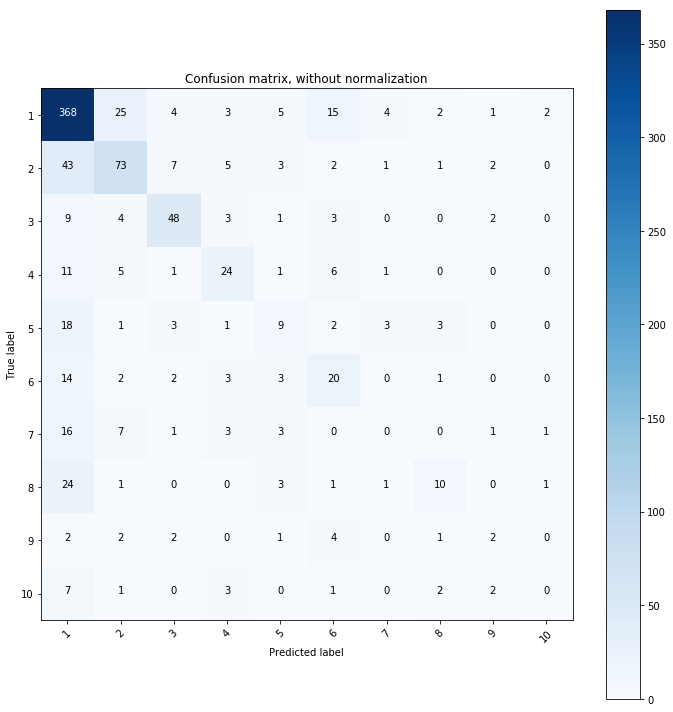

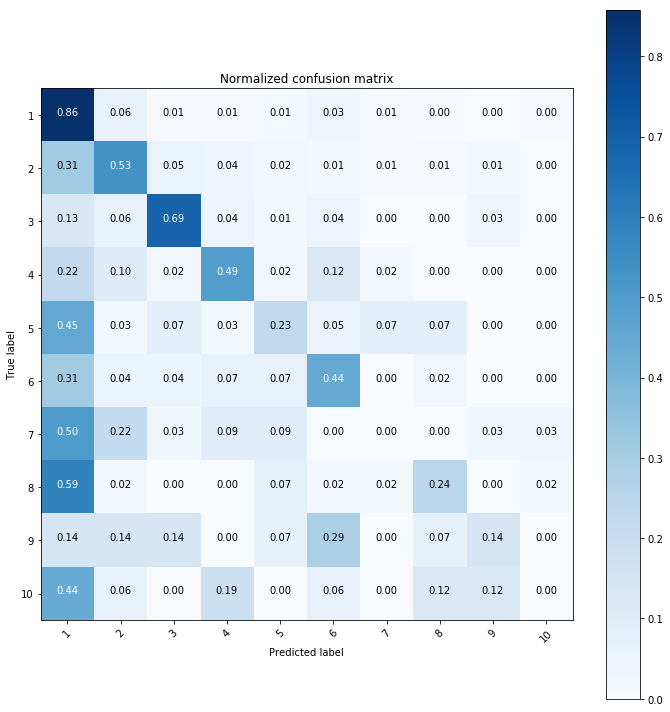

In [58]:
# print(__doc__)

import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

def plot_confusion_matrix(cm, classes=['1','2','3','4','5','6','7','8','9','10'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m,
                      title='Confusion matrix , without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

The confusion matrix produced by the regression based classifier indicates that the regression has trouble separating class 1 from other classes. Class 1 was by large the most abundant sample class available which explains why the simple regression classifies too many samples to class 1.

In contrast, the neural network based implementation has a much better confusion matrix though it also has some problem separating the rest of the classes from class 1. Not as much as regression, though. 

Confusion matrix, without normalization
Normalized confusion matrix


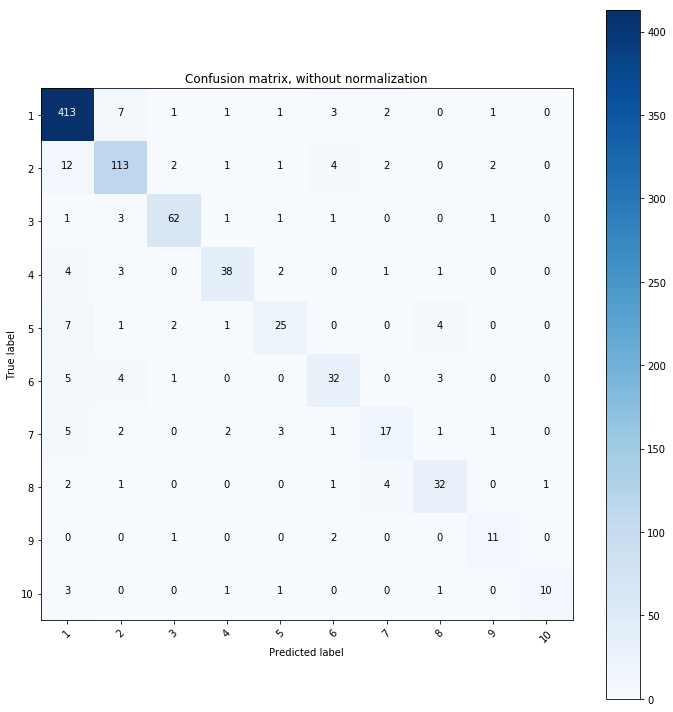

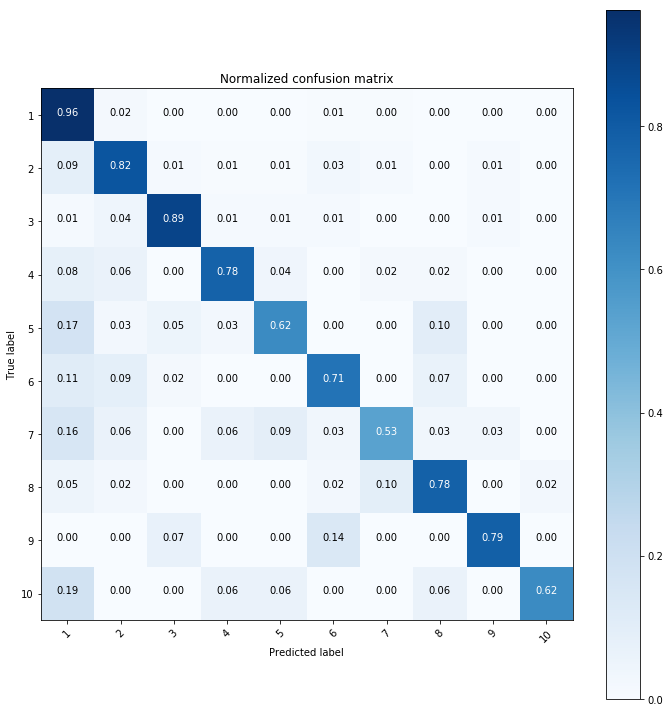

In [59]:
test_data = [
	val_data[:, :168],
	val_data[:, 168:216],
	val_data[:, 216:]
]
prediction_net = model.predict(test_data)
y_classes = prediction_net.argmax(axis=-1) # convert probabilities into labels
y_classes = np.subtract(y_classes, [-1]*len(y_classes))

conf_m = confusion_matrix(val_labels, y_classes)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 5. Discussion/Conclusions

The neural network yielded similar results to the logistic regression with slightly higher performance. Since we wanted to use the same network for both competitions we were not able to tailor the model for the individual competitions which may affect the overall performance of the model. First problem we ran into when designing the network were that the network learned the class distribution of the training dataset instead of generalizing based on the features. Unbalanced data remains a non-trivial problem to be solved.

It might be feasible to build a pipeline for the classification: since the classes are quite inbalanced (for example, class 1 being almost half of the samples) we could build a classifier that tells us whether a sample belongs to class 1 or not. Latter result makes the model advance in its pipeline to a classifier that classifies a somewhat evenly distributed dataset next (for example, classes 4-8 in the next classifier). Then it could advance to a stage where it checks whether a sample belongs to class 2 or to set of classes (3, 9, 10). Latter result would then differentiate between class 3 and set (9, 10) and then at the last stage it would identify whether the sample belongs to class 9 or class 10.

Class inbalance could also be handled with creating dummy data. We tried duplicating the low-count samples and sometimes even mutating them to make them distinct from the original data but this kind of preprocessing did not give us better results. A generative adversarial network may yield sufficient results for this purpose but we did not have the time to test GANs [2].

The neural net performed quite well (64% accuracy) as did the logistic regression (62% accuracy). We were unable to achieve results over 70% with the validation data (checking was done during the training). We tried different optimizers and went with Adam since it can be expected to converge faster than other optimizers [1].

## 6. References

 [1] https://arxiv.org/abs/1412.6980v8
 
 [2] https://arxiv.org/abs/1406.2661

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *